# Loading data and preprocessing

In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')


In [2]:
# Load the data
path = 'data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/'
data = {f: pd.read_csv(path + f + '.csv') for f in ['campaign_desc', 'campaign_table',
                                                    'causal_data', 'coupon', 'coupon_redempt',
                                                    'hh_demographic', 'product',
                                                    'transaction_data']}

# Checking for NaN data

In [3]:
def data_missing(dataframes):
    any_missing_data = False

    for (name, dataframe) in dataframes.items():
        any_missing_data = any_missing_data | dataframe.isna().values.any()

    return any_missing_data

print('NaN Data: %r' % data_missing(data))
data['hh_demographic'].head()

NaN Data: False


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


# Checking for other anomalies in the data

<font color = "green">

* As we can see we do not have any **NaN** data, so we do not have to worry about preprocessing, but we have indeed values that have the **Unknown** string instead of something valid. For this type of missing data we will not use lines that are marked with **Unknown** when creating plots if we need to know the value of that column.

In [4]:
data['product']['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

<font color = "green">
    
* Inspecting the `product` dataframe we see that there is a department name that contains only on space in its name. We shall print those lines to see if they have relevant information and if the haven't we shall remove them.

In [5]:
data['product'][data['product']['DEPARTMENT'].apply(lambda e: len(e)) == 1]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
52189,5126087,1,,National,,,
52190,5126088,1,,National,,,
52191,5126106,1,,National,,,
52192,5126107,1,,National,,,
55048,5977100,1,,National,,,
55054,5978648,1,,National,,,
55055,5978649,1,,National,,,
55056,5978650,1,,National,,,
55057,5978656,1,,National,,,
55058,5978657,1,,National,,,


<font color = "green">
    
* The above dataframe contains only 15 entries that do not tell anything, so we remove them.

In [6]:
data['product'] = data['product'][data['product']['DEPARTMENT'].apply(lambda e: len(e)) > 1]
data['product']['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

<font color = "green">

* We can notice that all the departments have a valid name now.

## Merge transactions set with other metadata

In [7]:
transactions = data["transaction_data"]\
                .merge(data["hh_demographic"], on="household_key", how="left")\
                .merge(data["product"], on="PRODUCT_ID", how="left")

## Compute some time based features

In [8]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [9]:
# Analyze weekday distribution
transactions.groupby("WEEK_NO")["DAY"].unique()

WEEK_NO
1                          [1, 2, 3, 4, 5]
2                 [6, 7, 8, 9, 10, 11, 12]
3             [13, 14, 15, 16, 17, 18, 19]
4             [20, 21, 22, 23, 24, 25, 26]
5             [27, 28, 29, 30, 31, 32, 33]
                      ...                 
98     [678, 679, 680, 681, 682, 683, 684]
99     [685, 686, 687, 688, 689, 690, 691]
100    [692, 693, 694, 695, 696, 697, 698]
101    [699, 700, 701, 702, 703, 704, 705]
102         [706, 707, 708, 709, 710, 711]
Name: DAY, Length: 102, dtype: object

<font color = "green">

* We can see that first and last week are underrepresented, so we will drop them. The second week starts at 6 so we will devise this to be 1st day of the week.

* Unfortunately we cannot exactly say which day is which weekday, 1st day can be Monday or Sunday based on two most common weekday numbering schemes.

* In further analyses we have seen bigger sales on two last days of the week so we hypothesize this is the weekend (so that would mean first day is Monday) - this will be explained in a further section.

In [10]:
transactions["DAY_OF_WEEK"] = (transactions["DAY"] - 6) % 7 + 1

In [11]:
transactions["HOUR"] = np.floor(transactions.TRANS_TIME / 100).apply(int)

In [12]:
# We look at a random sample of the time features we generated to make sure they look ok
transactions[["HOUR", "DAY_OF_WEEK", "WEEK_NO", "DAY", "MONTH"]].sample(5)

,HOUR,DAY_OF_WEEK,WEEK_NO,DAY,MONTH
1570173,7,6,66,459,16
521513,11,1,29,195,7
2217923,12,6,89,620,21
1395886,13,4,60,415,14
423413,11,3,25,169,6


## Create a demographic and product dataframe

In [13]:
missing_demographic = 100 * transactions.HOMEOWNER_DESC.isna().sum() / transactions.shape[0]
print(f"{missing_demographic}% of transactions doesn't have demographic data")

45.01346826251709% of transactions doesn't have demographic data


<font color = "green">
    
* Since some transactions are missing demographic data, we create a dataframe that contains only transactions with demographic data for demographic analysis, and a second dataframe without these columns for other tasks.

In [14]:
demographic_columns = list(data['hh_demographic'].columns[:-1])

In [15]:
transactions_demographic = transactions.dropna(subset=demographic_columns)

In [16]:
transactions_products = transactions.drop(columns=demographic_columns).dropna()

In [17]:
transactions_demographic.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,MONTH,DAY_OF_WEEK,HOUR
11,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,...,None/Unknown,69.0,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ,1,3,15
12,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,...,None/Unknown,1075.0,GROCERY,National,CRACKERS/MISC BKD FD,SNACK CRACKERS,9.5 OZ,1,3,15
13,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,...,None/Unknown,3664.0,MEAT,National,BEEF,GRND/PATTY - ROUND,,1,3,15
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,...,None/Unknown,2209.0,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW,12OZ,1,3,15
15,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,...,None/Unknown,69.0,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ,1,3,15


In [18]:
transactions_demographic.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'MANUFACTURER', 'DEPARTMENT', 'BRAND',
       'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT', 'MONTH',
       'DAY_OF_WEEK', 'HOUR'],
      dtype='object')

In [19]:
transactions_products.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,COUPON_MATCH_DISC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,MONTH,DAY_OF_WEEK,HOUR
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,0.0,69.0,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,1,3,16
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,0.0,2.0,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,1,3,16
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,0.0,69.0,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,,1,3,16
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,0.0,2.0,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,1,3,16
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,0.0,69.0,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,1,3,16


In [20]:
transactions_products.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'MANUFACTURER', 'DEPARTMENT',
       'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT',
       'MONTH', 'DAY_OF_WEEK', 'HOUR'],
      dtype='object')

# Question 2: How living status of a person (owner or renter, married or unmaried) influences the buying habits


In [21]:
dataframes = data
demographic_df = data['hh_demographic']

## Create dataframes for owners and renters

In [22]:
home_owner_df = demographic_df[demographic_df['HOMEOWNER_DESC'].apply(lambda e: e.lower()).str.contains('owner')]
renter_df = demographic_df[demographic_df['HOMEOWNER_DESC'].apply(lambda e: e.lower()).str.contains('renter')]

In [23]:
salary_ranges = list(demographic_df['INCOME_DESC'].unique())
age_ranges = list(demographic_df['AGE_DESC'].unique())

age_ranges.sort(key = lambda e: int(e.split('-')[0]) if len(e.split('-')[0]) == 2 else \
                        int(e.split('-')[0][: -1]))
salary_ranges.sort(key = lambda e: 0 if e.split('-')[0][0] == 'U' else \
                       int(e.split('-')[0][: -2] if len(e.split('-')) == 1 else \
                       int(e.split('-')[0])))

### Salary distribution per age ranges

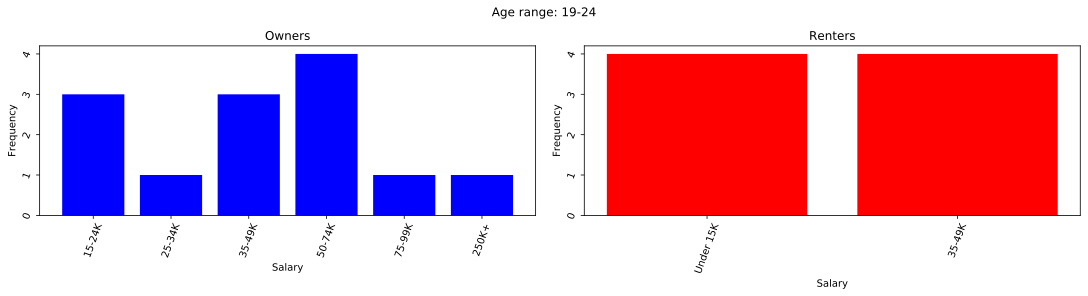

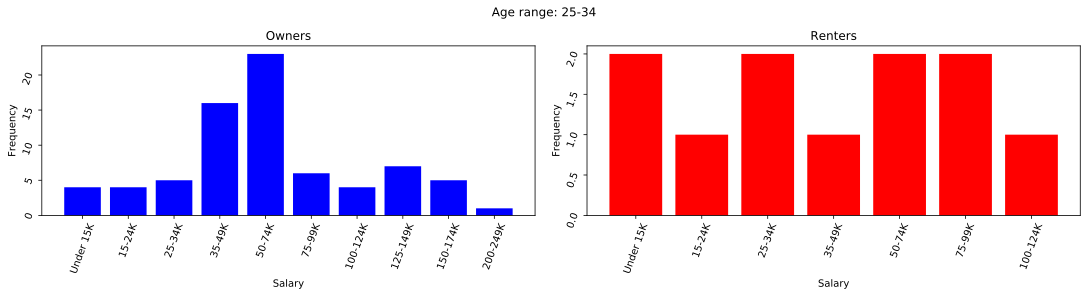

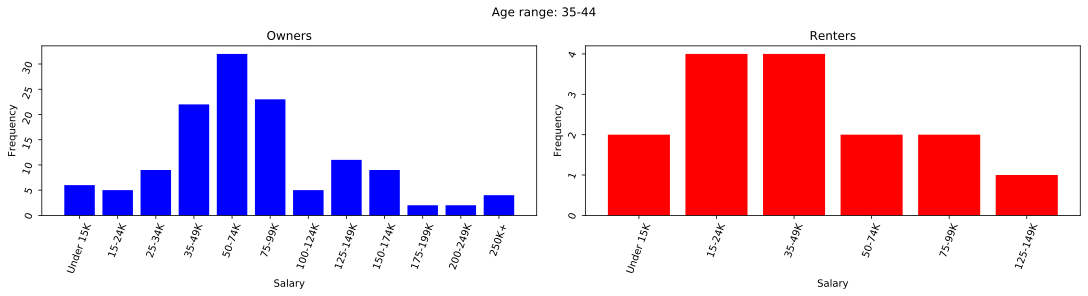

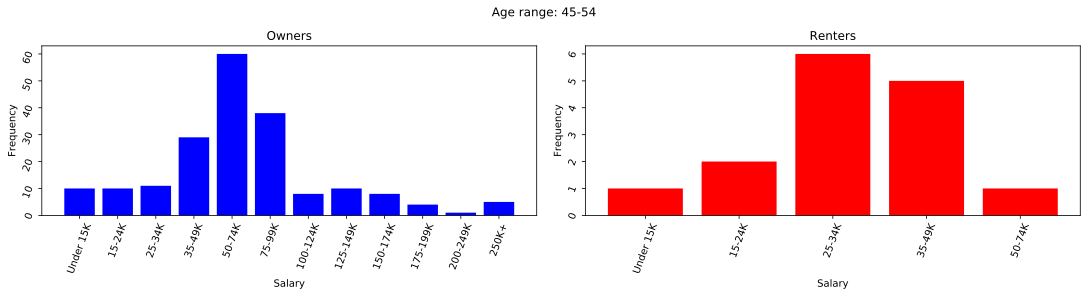

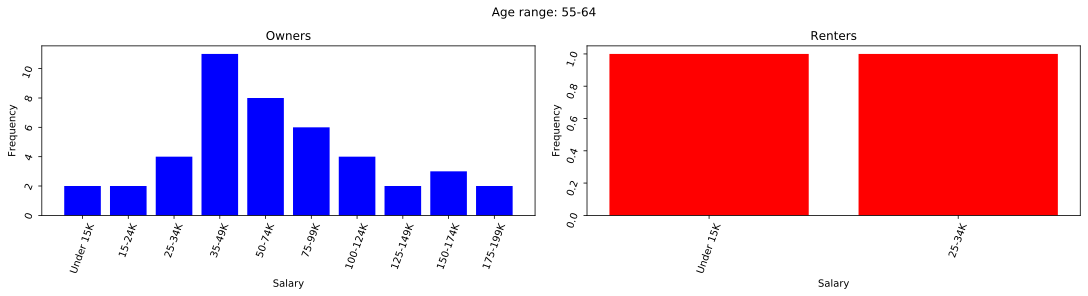

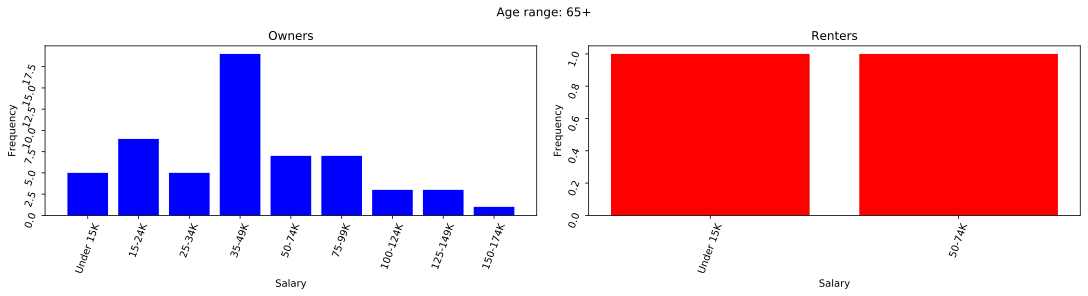

In [24]:
salary_distribution_owners = home_owner_df.groupby(['AGE_DESC', 'INCOME_DESC']).size()
salary_distribution_renters = renter_df.groupby(['AGE_DESC', 'INCOME_DESC']).size()
labels = list(salary_distribution_renters.index)

for age in age_ranges:
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True, figsize = [15, 4])
    items_owners = list(salary_distribution_owners[age].items())
    items_renters = list(salary_distribution_renters[age].items())

    items_owners.sort(key = lambda e: 0 if e[0].split('-')[0][0] == 'U' else \
                       int(e[0].split('-')[0][: -2] if len(e[0].split('-')) == 1 else \
                       int(e[0].split('-')[0])))
    items_renters.sort(key = lambda e: 0 if e[0].split('-')[0][0] == 'U' else \
                       int(e[0].split('-')[0][: -2] if len(e[0].split('-')) == 1 else \
                       int(e[0].split('-')[0])))

    x_pos_owners = np.arange(len(items_owners))
    x_pos_renters = np.arange(len(items_renters))
    
    ax1.bar(x = x_pos_owners, height = [e[1] for e in items_owners], color = 'blue', tick_label = [e[0] for e in items_owners])
    ax1.set_title('Owners')
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Salary')
    
    ax2.bar(x = x_pos_renters, height = [e[1] for e in items_renters], color = 'red', tick_label = [e[0] for e in items_renters])
    ax2.set_title('Renters')
    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Salary')

    ax1.tick_params(labelrotation = 70)
    ax2.tick_params(labelrotation = 70)
    
    fig.suptitle('Age range: %s' % age)
    plt.show()

<font color = "green">

* Most of the people are owners and by looking at every age category we observe that their salaries are normally distributed. 
* From their salaries we expect to see that the average value of products bought by owners to be higher than the average value of products of renters

### Average price per transaction for all age ranges

In [25]:
owners_transactions_df = pd.merge(home_owner_df, dataframes['transaction_data'], how = 'inner', on = 'household_key')
renters_transactions_df = pd.merge(renter_df, dataframes['transaction_data'], how = 'inner', on = 'household_key')

owners_transactions_df['TRANSACTION_VALUE'] = owners_transactions_df['SALES_VALUE'] - \
                                            (owners_transactions_df['RETAIL_DISC'] + \
                                             owners_transactions_df['COUPON_MATCH_DISC'])
renters_transactions_df['TRANSACTION_VALUE'] = renters_transactions_df['SALES_VALUE'] - \
                                            (renters_transactions_df['RETAIL_DISC'] + \
                                             renters_transactions_df['COUPON_MATCH_DISC'])

owners_prices_per_age = owners_transactions_df.groupby('AGE_DESC')['TRANSACTION_VALUE'].mean()
renters_prices_per_age = renters_transactions_df.groupby('AGE_DESC')['TRANSACTION_VALUE'].mean()

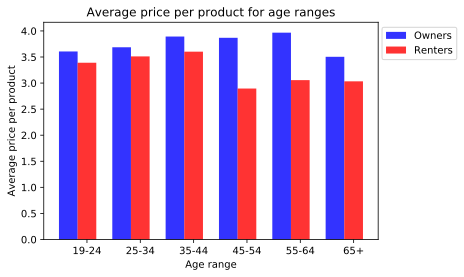

In [26]:
fig, ax = plt.subplots()
index = np.arange(owners_prices_per_age.shape[0])
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, [e[1] for e in owners_prices_per_age.items()], \
                 bar_width, alpha = opacity, color = 'blue', label = 'Owners')
rects2 = plt.bar(index + bar_width, [e[1] for e in renters_prices_per_age.items()], \
                 bar_width, alpha = opacity, color='red', label = 'Renters')

plt.xticks(index + bar_width, [e[0] for e in owners_prices_per_age.items()])
plt.xlabel('Age range')
plt.ylabel('Average price per product')
plt.title('Average price per product for age ranges')
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.show()

In [27]:
print('Number of owners: %d' % home_owner_df.shape[0])
print('Number of renters: %d' % renter_df.shape[0])

Number of owners: 515
Number of renters: 53


<font color = "green">

* Indeed, we can see that owners tend to spend more money on products on all age ranges.
* It is worth noticing that this might be biased due to very big difference in numbers of between renteres and owners. **Renters represent aproximatively 10% of the total number of owners.**

### Influence of coupons over renters and owners

In [28]:
# Obtain the coupons redempt by both renters and owners
coupons_redempt_owners = pd.merge(dataframes['coupon_redempt'], home_owner_df, how = 'inner', on = ['household_key'])
coupons_redempt_renters = pd.merge(dataframes['coupon_redempt'], renter_df, how = 'inner', on = ['household_key'])

Age Range
19-24     8
25-34    11
35-44    15
45-54    15
55-64     2
65+       2
Name: Number of renters per age range, dtype: int64
Age Range
19-24    14
25-34    24
35-44    34
45-54    22
55-64     1
Name: Number coupons redeemed per number of renters of age range, dtype: int64


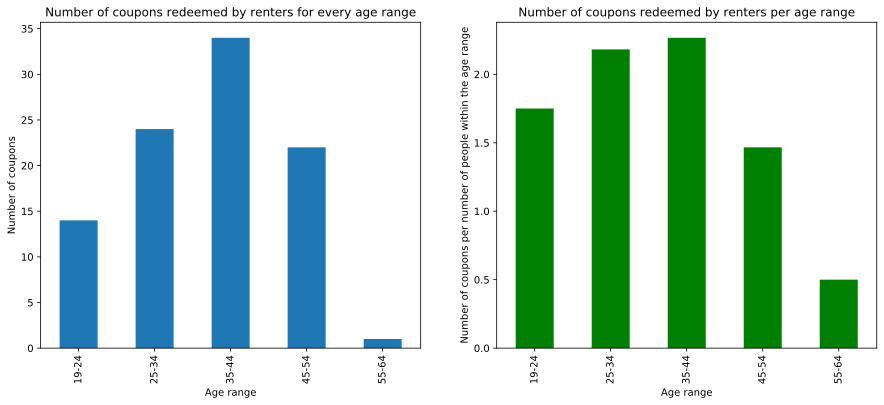

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

unnormalized = coupons_redempt_renters.groupby('AGE_DESC').size()
group_size = renter_df.groupby('AGE_DESC').size()

ax1 = unnormalized.plot.bar(ax = ax1)
ax1.set_title('Number of coupons redeemed by renters for every age range')
ax1.set_ylabel('Number of coupons')
ax1.set_xlabel('Age range')

ax2 = (1. * unnormalized / group_size)[: -1].plot.bar(ax = ax2, color = 'green')
ax2.set_title('Number of coupons redeemed by renters per age range')
ax2.set_ylabel('Number of coupons per number of people within the age range')
ax2.set_xlabel('Age range')

group_size.index.name = 'Age Range'
group_size.name = 'Number of renters per age range'

print(group_size)

unnormalized.index.name = 'Age Range'
unnormalized.name = 'Number coupons redeemed per number of renters of age range'

print(unnormalized)

<font color = "green">

* We see the proportions of coupons per age range are comparable even if the the numbers from people of differente ages are different.
* Also, looking at the at the 2 series from above the plots we see that none of the renters above 65 years old redeemed any coupon.

Age Range
19-24     13
25-34     75
35-44    130
45-54    194
55-64     44
65+       59
Name: Number of owners per age range, dtype: int64

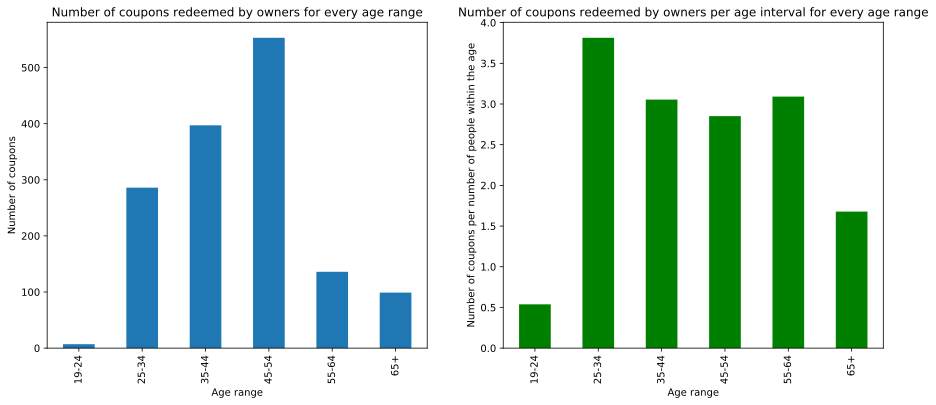

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

unnormalized = coupons_redempt_owners.groupby('AGE_DESC').size()
group_size = home_owner_df.groupby('AGE_DESC').size()

ax1 = unnormalized.plot.bar(ax = ax1)
ax1.set_title('Number of coupons redeemed by owners for every age range')
ax1.set_xlabel('Age range')
ax1.set_ylabel('Number of coupons')

ax2 = (unnormalized / group_size).plot.bar(ax = ax2, color = 'green')
ax2.set_title('Number of coupons redeemed by owners per age interval for every age range')
ax2.set_xlabel('Age range')
ax2.set_ylabel('Number of coupons per number of people within the age')

group_size.index.name = 'Age Range'
group_size.name = 'Number of owners per age range'
group_size

<font color = "green">

* It is not worth comparing the number of coupons redeemed, because as we can see from the series from the above, the number of people within 45-54 years old is bigger than any number of people from any other age ranges. So we divide the number of coupons redeemed at the number of people from within the age range and we get the plot from the right.
* Now the comparison is a more fair as it emphasizes that the ratio of coupons redeemed by people between 55-64 years old is comparable with the other ratios (fact that was hardto guess from the first plot)
* An interesting observation would be the comparison between owners and renters for people between 19024 years old. Even though the number of people is quite the same, renters between 19-24 redeem 3 times more coupons than the owners within the same age, which is fair if you have a rent and want to save money.
* Looking at the above 4 plots we see that people like to use coupons and get cheaper products.

# Number of coupons received by onwers and renters

In [31]:
# Merge dataframe of owners with `campaign_table` to see how many coupons the owner received
types_of_coupons_received_owners = pd.merge(home_owner_df, dataframes['campaign_table'], how = 'inner', on = 'household_key')
types_of_coupons_received_owners = types_of_coupons_received_owners.groupby(['AGE_DESC', 'DESCRIPTION']).size()

# Merge dataframe of owners with `campaign_table` to see how many coupons the renters received
types_of_coupons_received_renters = pd.merge(renter_df, dataframes['campaign_table'], how = 'inner', on = 'household_key')
types_of_coupons_received_renters = types_of_coupons_received_renters.groupby(['AGE_DESC', 'DESCRIPTION']).size()

In [32]:
def plot_number_of_coupons_received(series, age_ranges, ax, index, bar_width, opcacity, title, xlabel, ylabel):
    campaigns_type_a, campaigns_type_b, campaigns_type_c  = [], [], []

    for age_range in age_ranges:
        if 'TypeA' in series[age_range]:
            campaigns_type_a.append(series[age_range]['TypeA'])
        else:
            campaigns_type_a.append(0)

        if 'TypeB' in series[age_range]:
            campaigns_type_b.append(series[age_range]['TypeB'])
        else:
            campaigns_type_b.append(0)

        if 'TypeC' in series[age_range]:
            campaigns_type_c.append(series[age_range]['TypeC'])
        else:
            campaigns_type_c.append(0)

    ax.bar(index, campaigns_type_a, bar_width, alpha = opacity, color = 'blue', \
                               label = 'Campaigns TypeA')
    ax.bar(index + bar_width, campaigns_type_b, bar_width, alpha = opacity, color = 'red', \
                               label = 'Campaigns TypeB')
    ax.bar(index + 2 * bar_width, campaigns_type_c, bar_width, alpha = opacity, color = 'green', \
                               label = 'Campaigns TypeC')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

Age Range
19-24     13
25-34     75
35-44    130
45-54    194
55-64     44
65+       59
Name: Number of owners per age range, dtype: int64
Age Range
19-24     8
25-34    11
35-44    15
45-54    15
55-64     2
65+       2
Name: Number of owners per age range, dtype: int64


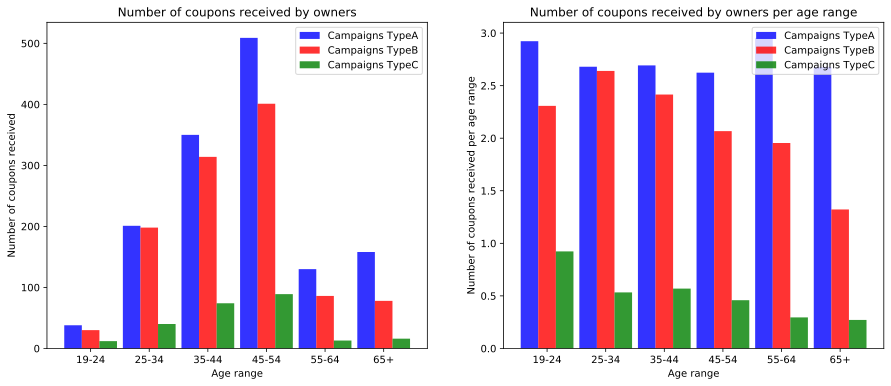

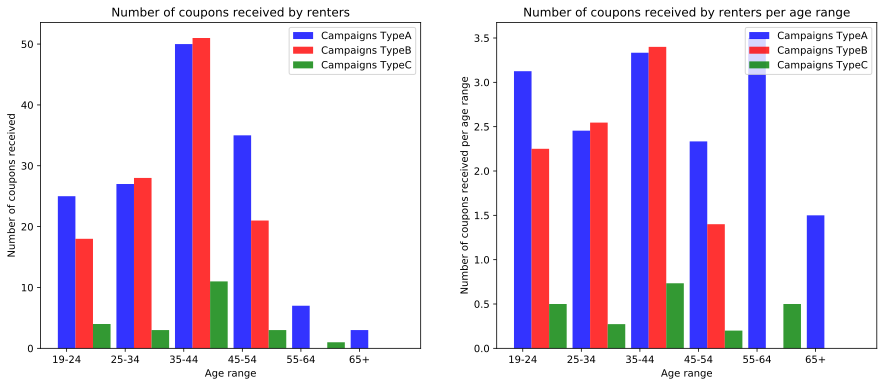

In [33]:
# Number of people from every age range
group_size_owners = home_owner_df.groupby('AGE_DESC').size()
group_size_renters = renter_df.groupby('AGE_DESC').size()

index = np.arange(group_size_renters.shape[0])
bar_width = 0.3
opacity = 0.8

# Plot for owners
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])
plt.setp((ax1, ax2), xticks = index + bar_width, xticklabels = list(group_size_owners.index))

plot_number_of_coupons_received(types_of_coupons_received_owners, age_ranges, ax1, index, bar_width, opacity, \
                                'Number of coupons received by owners', 'Age range', 'Number of coupons received')

plot_number_of_coupons_received(types_of_coupons_received_owners / group_size_owners, age_ranges, \
                                ax2, index, bar_width, opacity, 'Number of coupons received by owners per age range', \
                                'Age range', 'Number of coupons received per age range')

# Plot for renters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])
plt.setp((ax1, ax2), xticks = index, xticklabels = list(group_size_renters.index))

plot_number_of_coupons_received(types_of_coupons_received_renters, age_ranges, ax1, index, bar_width, opacity, \
                                'Number of coupons received by renters', 'Age range', 'Number of coupons received')

plot_number_of_coupons_received(types_of_coupons_received_renters / group_size_renters, age_ranges, \
                                ax2, index, bar_width, opacity, 'Number of coupons received by renters per age range', \
                                'Age range', 'Number of coupons received per age range')

group_size_owners.index.name = 'Age Range'
group_size_owners.name = 'Number of owners per age range'

group_size_renters.index.name = 'Age Range'
group_size_renters.name = 'Number of owners per age range'


print(group_size_owners)
print(group_size_renters)

<font color = "green">

* Looking at the 2 plots from the left for both owners and renters we see that people with ages between 45-54 years old (for owners) and 35-44 years old (for owners) received more tickets because they are more than the othe peple in other catagories.
* Looking at the plots from the right, that denote the number of coupons in average received by a person within a certain age range, we see that the number of campaign people are advertised with does not seem to depend on the age, stores trying to win as more clients as possible.

# What kind of people redeemed the coupons and on what kind of products

<font color = "green">

We will look a little bit more in depth on how people spent the coupons depending on the families these come from

In [34]:
people = dataframes['hh_demographic']

# Obtain transaction where coupons were redeemed
coupons_redeemed = pd.merge(people, dataframes['coupon_redempt'], how = 'inner', on = 'household_key')
group_size_families = home_owner_df.groupby('HH_COMP_DESC').size()

HH_COMP_DESC
1 Adult Kids         25
2 Adults Kids       146
2 Adults No Kids    206
Single Female        63
Single Male          38
Unknown              37
dtype: int64

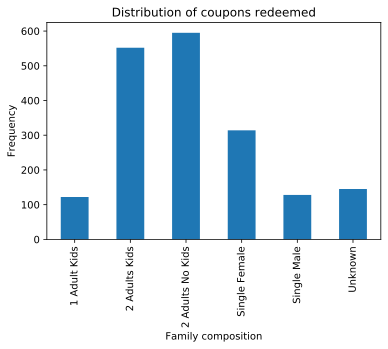

In [35]:
ax = coupons_redeemed.groupby('HH_COMP_DESC').size().plot.bar()
ax.set_xlabel('Family composition')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of coupons redeemed')

group_size_families

<font color = "green">

* Indeed, we can see in the above plot that families that have kids redeem more coupons (looking at the bar with with **1 Adult Kids** and **2 Adults Kids**) as their number is bigger, so the comparison would not be fair without dividing by the number of households from every category.

In [36]:
# Dataframe with all the transactions
transactions_df = pd.merge(people, dataframes['transaction_data'], how = 'inner', on = 'household_key')
transactions_products_df = pd.merge(transactions_df, dataframes['product'], how = 'inner', on = 'PRODUCT_ID')

In [37]:
groceries = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                     isin(['GROCERY', 'PASTRY', 'GRO BAKERY', 'PASTRY', \
                                           'FROZEN GROCERY'])].groupby('HH_COMP_DESC').size()
meat = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['MEAT-PCKGD', 'MEAT', 'MEAT-WHSE', 'PORK'])].\
                                groupby('HH_COMP_DESC').size()
seafood = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['SEAFOOD-PCKGD', 'SEAFOOD'])].groupby('HH_COMP_DESC').size()
medicines = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['DRUG GM', 'PHARMACY SUPPLY'])].groupby('HH_COMP_DESC').size()
nutrition = transactions_products_df[transactions_products_df['DEPARTMENT'].\
                                isin(['NUTRITION'])].groupby('HH_COMP_DESC').size()

In [38]:
def plot_bar_series(series, xlabel, ylabel, title, ax, color = None):
    if color != None:
        ax = series.plot.bar(ax = ax, color = color)
    else:
        ax = series.plot.bar(ax = ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

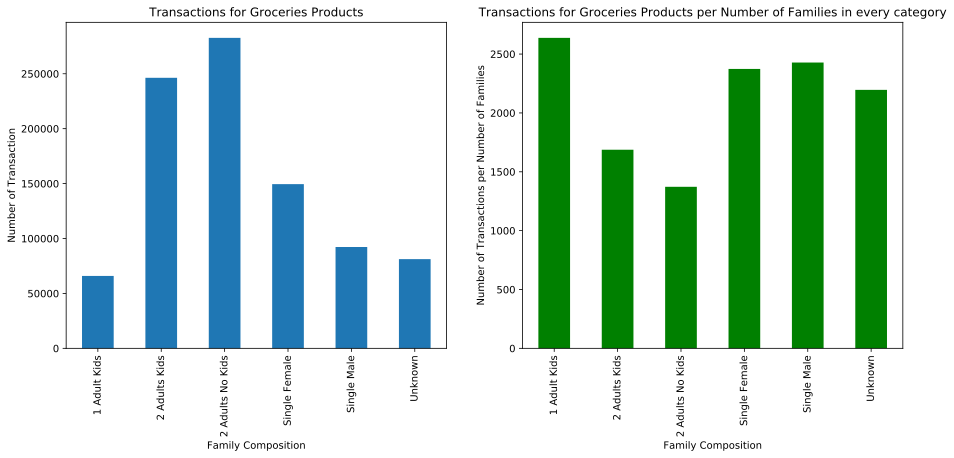

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(groceries, 'Family Composition', 'Number of Transaction', \
                'Transactions for Groceries Products', ax1)
plot_bar_series(groceries / group_size_families, 'Family Composition', 'Number of Transactions per Number of Families', \
                'Transactions for Groceries Products per Number of Families in every category', ax2, color = 'green')

<font color = "green">
    
* The second plot provides a more honest comparison as we can notice that despite there are far less transactions for families with only 1 parent (because they are much less than families with 2 parents) we see that they buy groceries much more frequent  than families with 2 adults (with or without kids)

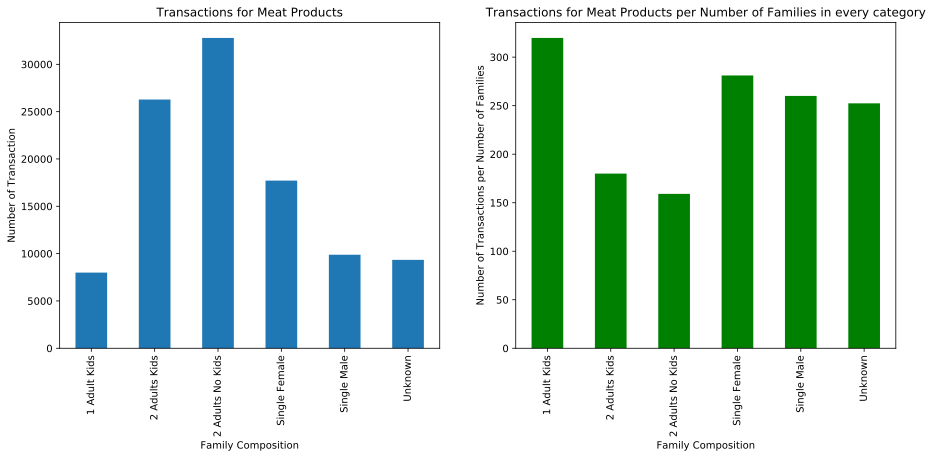

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(meat, 'Family Composition', 'Number of Transaction', 'Transactions for Meat Products', ax1)
plot_bar_series(meat / group_size_families, 'Family Composition', 'Number of Transactions per Number of Families', \
                'Transactions for Meat Products per Number of Families in every category', ax2, color = 'green')

<font color = "green">
    
* We see again the same behavior as in the plots for groceries, families with 1 adult buying more frequent than the others
* It is interesting to remark that signle females buy meat more frequently than men.

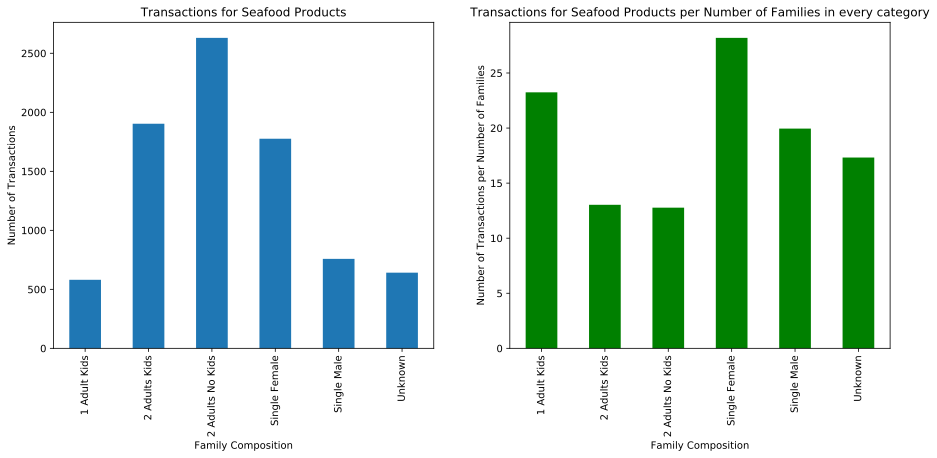

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(seafood, 'Family Composition', 'Number of Transactions', 'Transactions for Seafood Products', ax1)
plot_bar_series(seafood / group_size_families, 'Family Composition', 'Number of Transactions per Number of Families', \
                'Transactions for Seafood Products per Number of Families in every category', ax2, color = 'green')

<font color = "green">

* The trend does not seem to change.

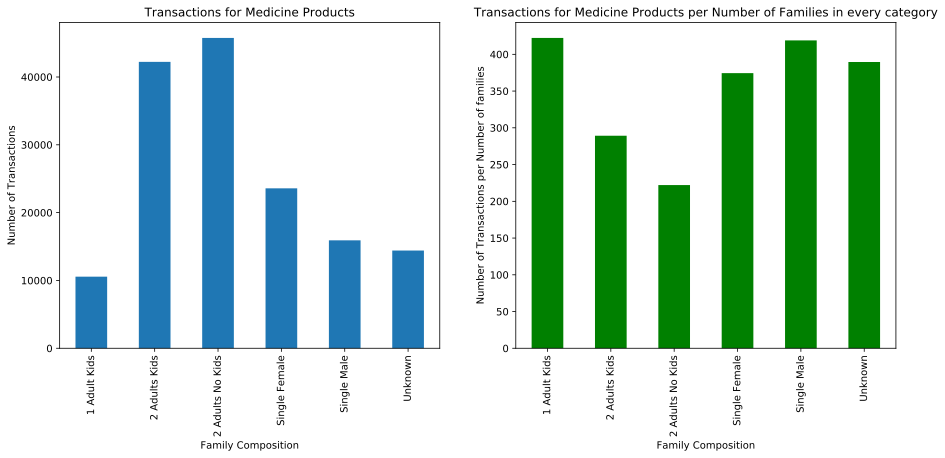

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(medicines, 'Family Composition', 'Number of Transactions', 'Transactions for Medicine Products', ax1)
plot_bar_series(medicines / group_size_families, 'Family Composition', 'Number of Transactions per Number of families', \
                'Transactions for Medicine Products per Number of Families in every category', ax2, color = 'green')

<font color = "green">

* The trend does not seem to change.

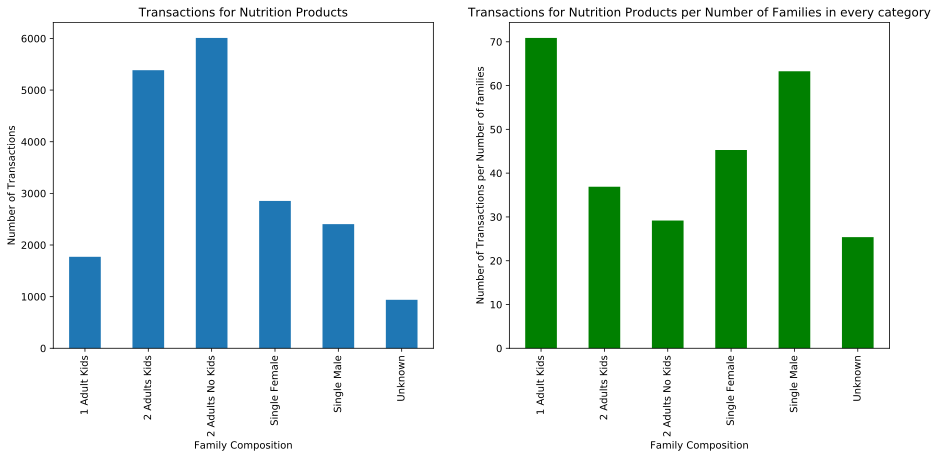

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [15, 6])

plot_bar_series(nutrition, 'Family Composition', 'Number of Transactions', 'Transactions for Nutrition Products', ax1)
plot_bar_series(nutrition / group_size_families, 'Family Composition', 'Number of Transactions per Number of families', \
                'Transactions for Nutrition Products per Number of Families in every category', ax2, color = 'green')

In [44]:
dataframes['product'][dataframes['product']['DEPARTMENT'] == 'NUTRITION']['SUB_COMMODITY_DESC'].unique()

array(['SOY BEVERAGE', 'TORTILLA CHIPS', 'DRINKS - CARB JUICE (OVER 50%',
       'RAISINS', 'POTATO CHIPS', 'FROZEN PIZZA', 'DRIED FRUIT - OTHER',
       'SPRING WATER', 'CEREAL - COLD', 'SOY/RICE MILK',
       'COOKIES/SWEET GOODS', 'FITNESS&DIET - BARS', 'SALSA/DIPS', 'MISC',
       'ASEPTIC MILK', 'TEA SWEETENED', 'SPECIALTY CHIPS (SOY CRISPS/PI',
       'JUICE (UNDER 10% JUICE)', 'RICE CAKES', 'YOGURT', 'PASTA/RAMEN',
       'FLUID MILK', 'MEATLESS/VEGETARIAN', 'LARGE - RICE CAKES',
       'DRIED FRUIT', 'FROZEN VEGETABLES',
       'BOXED PREPARED/ENTREE/DRY PREP', 'NON-CARB JCE (UNDER 50%JCE)',
       'DRESSINGS', 'SPECIALTY SNACKS (SOYNUTS/TRAI',
       'JUICE (OVER 50% JUICE)', 'CRACKERS', 'HONEY/SYRUP',
       'CANDY/CHOCOLATE', 'GRANOLA', 'NON-CARB JCE(OVER 50% JCE)',
       'VEGETABLES/DRY BEANS', 'BROTHS', 'FROZEN MEAT (VEGETARIAN)',
       'SPORTS NUTRITION', 'VEGETARIAN MISC', 'TOFU', 'FROZEN ENTREES',
       'FRZN MEAT ALTERNATIVES', 'NUT REFRIG JUICE OVER 50%',
       'B

<font color = "green">

* We see that single males byt more nutrtion products than signle women. If we look at the list of unique products from nutrition category we see that these products are not so healthy (like FROZEN BURGERS, CANDY W/O FLOUR etc).
* It seem that single females pay more attention with when they are going to shopping than single men.

<font color = "green">
    
* Looking at the 8 plots above (number of transactions for **groceries**, **meat**, **seafod** and **medicine**) unnormalized (on the left) and normalized (on the right) we draw the conclusion that families with 2 adults (with and withou kids) have more balanced behavior when it comes about shopping. We can notice that by looking at the plots on the right that the frequency of transactions for these 2 groups is smalles than the frequqncy of transactions for the other groups.
* Single females tend to have the same frequency of buying with single men, though it is to remark that they buy healthier products (they have a higher freuqncy than single men when it comes about seafood and meat products, a comparable frequency of buying groceries and a smaller frquency of buying nutrition products which are mostly dominated by unhealthy products.